In [70]:
HQA_MNIST_SAVE_PATH = './checkpoints/hqa_mnist.pt'
CLASSIFIER_MNIST_SAVE_PATH = './checkpoints/lenet_mnist.pt'


In [71]:
import torch
import torchattacks
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

import os

from hqa_lightning import train_hqa_mnist, HQA2D_Lightning
from lenet5 import LeNet5, get_preds
from data import get_mnist_dataloaders


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)
dl_train, dl_test = get_mnist_dataloaders()

Device:  cuda


In [72]:
if os.path.exists(HQA_MNIST_SAVE_PATH):
    hqa_model = torch.load(HQA_MNIST_SAVE_PATH).to(device)
    print(f"Loaded {len(hqa_model)} layer model from checkpoint.")
else:
    hqa_model = train_mnist(max_epochs=1, devices=1)
    torch.save(hqa_model, HQA_MNIST_SAVE_PATH)

def reconstruct(layer, attack=None):
    def _reconstruct(x, y):
        if attack is not None:
            x = attack(x, y)
        if layer >= 0:
            x = x.to(hqa_model.device)
            x_recon = hqa_model[layer].reconstruct(x)
            return x_recon
        return x
    return _reconstruct

Loaded 5 layer model from checkpoint.


In [73]:
if os.path.exists(CLASSIFIER_MNIST_SAVE_PATH):
    lenet_model = torch.load(CLASSIFIER_MNIST_SAVE_PATH).to(device)
    print(f"Loaded MNIST classifier from checkpoint.")
else:
    hqa_model = train_mnist(max_epochs=1, devices=1)
    torch.save(hqa_model, HQA_MNIST_SAVE_PATH)

Loaded MNIST classifier from checkpoint.


In [74]:
accuracies_no_attack = []

Y, Y_pred = get_preds(lenet_model, dl_test)
accuracy = accuracy_score(Y,Y_pred)
print("Original Data Classification Accuracy: ", accuracy)
accuracies_no_attack.append(accuracy)

for index, layer in enumerate(hqa_model):
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index))
    accuracy = accuracy_score(Y,Y_pred)
    accuracies_no_attack.append(accuracy)
    print(f"Layer {index} Reconstructions Classification Accuracy: ", accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 55.31it/s]


Original Data Classification Accuracy:  0.9905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 20.13it/s]


Layer 0 Reconstructions Classification Accuracy:  0.9899


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.06it/s]


Layer 1 Reconstructions Classification Accuracy:  0.9857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.88it/s]


Layer 2 Reconstructions Classification Accuracy:  0.9518


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.40it/s]


Layer 3 Reconstructions Classification Accuracy:  0.851


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.78it/s]


Layer 4 Reconstructions Classification Accuracy:  0.7173


In [86]:
accuracies_fgsm_attack_01 = []
accuracies_fgsm_attack_05 = []
accuracies_fgsm_attack_07 = []
accuracies_fgsm_attack_10 = []
accuracies_fgsm_attack_20 = []

epsilons = [0.2, 0.01, 0.05, 0.07, 0.1]

eps_to_array = {
    0.01 : accuracies_fgsm_attack_01,
    0.05 : accuracies_fgsm_attack_05,
    0.07 : accuracies_fgsm_attack_07,
    0.1 : accuracies_fgsm_attack_10,
    0.2 : accuracies_fgsm_attack_20
}

for epsilon in epsilons:
    attack = torchattacks.FGSM(lenet_model, eps=epsilon)
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [FGSM eps={epsilon}] Accuracy: ", accuracy)
    eps_to_array[epsilon].append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        eps_to_array[epsilon].append(accuracy)
        print(f"Layer {index} Reconstructions [FGSM eps={epsilon}] Accuracy: ", accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 46.51it/s]


Attack [FGSM eps=0.2] Accuracy:  0.3359


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.72it/s]


Layer 0 Reconstructions [FGSM eps=0.2] Accuracy:  0.5521


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.18it/s]


Layer 1 Reconstructions [FGSM eps=0.2] Accuracy:  0.7144


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.83it/s]


Layer 2 Reconstructions [FGSM eps=0.2] Accuracy:  0.5377


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.59it/s]


Layer 3 Reconstructions [FGSM eps=0.2] Accuracy:  0.5751


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.66it/s]


Layer 4 Reconstructions [FGSM eps=0.2] Accuracy:  0.5626


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 48.12it/s]


Attack [FGSM eps=0.01] Accuracy:  0.9808


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.44it/s]


Layer 0 Reconstructions [FGSM eps=0.01] Accuracy:  0.9884


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.09it/s]


Layer 1 Reconstructions [FGSM eps=0.01] Accuracy:  0.9861


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.75it/s]


Layer 2 Reconstructions [FGSM eps=0.01] Accuracy:  0.9503


 15%|█████████████████████████                                                                                                                                              | 3/20 [00:00<00:02,  6.44it/s]


KeyboardInterrupt: 

In [63]:
accuracies_bim_attack_01 = []
accuracies_bim_attack_05 = []
accuracies_bim_attack_07 = []
accuracies_bim_attack_10 = []

epsilons = [0.01, 0.05, 0.07, 0.1]
arrays = [accuracies_bim_attack_01, accuracies_bim_attack_05, accuracies_bim_attack_07, accuracies_bim_attack_10]

# BIM Attack
for epsilon, array in zip(epsilons, arrays):
    attack = torchattacks.BIM(lenet_model, eps=epsilon, alpha=2/255, steps=10)
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [BIM eps={epsilon}] Accuracy: ", accuracy)
    array.append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        array.append(accuracy)
        print(f"Layer {index} Reconstructions [BIM eps={epsilon}] Accuracy: ", accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.86it/s]


Attack [BIM eps=0.01] Accuracy:  0.9778


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.98it/s]


Layer 0 Reconstructions [BIM eps=0.01] Accuracy:  0.9871


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.11it/s]


Layer 1 Reconstructions [BIM eps=0.01] Accuracy:  0.9848


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.08it/s]


Layer 2 Reconstructions [BIM eps=0.01] Accuracy:  0.9456


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.04it/s]


Layer 3 Reconstructions [BIM eps=0.01] Accuracy:  0.8505


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.84it/s]


Layer 4 Reconstructions [BIM eps=0.01] Accuracy:  0.7149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.52it/s]


Attack [BIM eps=0.05] Accuracy:  0.6963


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.04it/s]


Layer 0 Reconstructions [BIM eps=0.05] Accuracy:  0.9713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.09it/s]


Layer 1 Reconstructions [BIM eps=0.05] Accuracy:  0.9715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.06it/s]


Layer 2 Reconstructions [BIM eps=0.05] Accuracy:  0.9331


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.41it/s]


Layer 3 Reconstructions [BIM eps=0.05] Accuracy:  0.8378


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.84it/s]


Layer 4 Reconstructions [BIM eps=0.05] Accuracy:  0.7134


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.53it/s]


Attack [BIM eps=0.07] Accuracy:  0.5323


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.25it/s]


Layer 0 Reconstructions [BIM eps=0.07] Accuracy:  0.9516


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.21it/s]


Layer 1 Reconstructions [BIM eps=0.07] Accuracy:  0.9643


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.03it/s]


Layer 2 Reconstructions [BIM eps=0.07] Accuracy:  0.9231


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.36it/s]


Layer 3 Reconstructions [BIM eps=0.07] Accuracy:  0.8307


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.85it/s]


Layer 4 Reconstructions [BIM eps=0.07] Accuracy:  0.713


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.71it/s]


Attack [BIM eps=0.1] Accuracy:  0.4882


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.06it/s]


Layer 0 Reconstructions [BIM eps=0.1] Accuracy:  0.9415


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.13it/s]


Layer 1 Reconstructions [BIM eps=0.1] Accuracy:  0.9584


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.03it/s]


Layer 2 Reconstructions [BIM eps=0.1] Accuracy:  0.9189


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.37it/s]


Layer 3 Reconstructions [BIM eps=0.1] Accuracy:  0.8257


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.60it/s]


Layer 4 Reconstructions [BIM eps=0.1] Accuracy:  0.7089


In [83]:
accuracies_pgd_attack_01 = []
accuracies_pgd_attack_05 = []
accuracies_pgd_attack_07 = []
accuracies_pgd_attack_10 = []


overshoots = [0.01, 0.05, 0.07, 0.1]
arrays = [accuracies_pgd_attack_01, accuracies_pgd_attack_05, accuracies_pgd_attack_07, accuracies_pgd_attack_10]

# pgd Attack
for overshoot, array in zip(overshoots, arrays):
    attack = torchattacks.PGD(lenet_model, eps=overshoot)
    x, y = next(iter(dl_test))
    Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [pgd overshoot={overshoot}] Accuracy: ", accuracy)
    array.append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(lenet_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        array.append(accuracy)
        print(f"Layer {index} Reconstructions [pgd overshoot={overshoot}] Accuracy: ", accuracy)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.87it/s]


Attack [pgd overshoot=0.01] Accuracy:  0.98


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.13it/s]


Layer 0 Reconstructions [pgd overshoot=0.01] Accuracy:  0.9888


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.30it/s]


Layer 1 Reconstructions [pgd overshoot=0.01] Accuracy:  0.9856


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.26it/s]


Layer 2 Reconstructions [pgd overshoot=0.01] Accuracy:  0.9497


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.62it/s]


Layer 3 Reconstructions [pgd overshoot=0.01] Accuracy:  0.849


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.02it/s]


Layer 4 Reconstructions [pgd overshoot=0.01] Accuracy:  0.7191


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.81it/s]


Attack [pgd overshoot=0.05] Accuracy:  0.7133


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.41it/s]


Layer 0 Reconstructions [pgd overshoot=0.05] Accuracy:  0.9743


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.25it/s]


Layer 1 Reconstructions [pgd overshoot=0.05] Accuracy:  0.9738


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.22it/s]


Layer 2 Reconstructions [pgd overshoot=0.05] Accuracy:  0.9363


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.60it/s]


Layer 3 Reconstructions [pgd overshoot=0.05] Accuracy:  0.8381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.04it/s]


Layer 4 Reconstructions [pgd overshoot=0.05] Accuracy:  0.7145


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 18.12it/s]


Attack [pgd overshoot=0.07] Accuracy:  0.5497


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.96it/s]


Layer 0 Reconstructions [pgd overshoot=0.07] Accuracy:  0.9649


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.27it/s]


Layer 1 Reconstructions [pgd overshoot=0.07] Accuracy:  0.9689


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.21it/s]


Layer 2 Reconstructions [pgd overshoot=0.07] Accuracy:  0.9252


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.57it/s]


Layer 3 Reconstructions [pgd overshoot=0.07] Accuracy:  0.8303


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.73it/s]


Layer 4 Reconstructions [pgd overshoot=0.07] Accuracy:  0.7092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 17.67it/s]


Attack [pgd overshoot=0.1] Accuracy:  0.4347


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 10.16it/s]


Layer 0 Reconstructions [pgd overshoot=0.1] Accuracy:  0.9484


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.20it/s]


Layer 1 Reconstructions [pgd overshoot=0.1] Accuracy:  0.9615


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.16it/s]


Layer 2 Reconstructions [pgd overshoot=0.1] Accuracy:  0.9121


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.58it/s]


Layer 3 Reconstructions [pgd overshoot=0.1] Accuracy:  0.8192


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.98it/s]


Layer 4 Reconstructions [pgd overshoot=0.1] Accuracy:  0.7071


[0.9911, 0.9909, 0.9863, 0.9513, 0.8477, 0.7192]
[0.9793, 0.9888, 0.9829, 0.9491, 0.8426, 0.7171]
[0.8563, 0.9708, 0.9741, 0.9341, 0.8369, 0.7159]
[0.7728, 0.9535, 0.9618, 0.9177, 0.8233, 0.7032]
[0.6412, 0.9001, 0.9358, 0.8567, 0.7833, 0.6916]


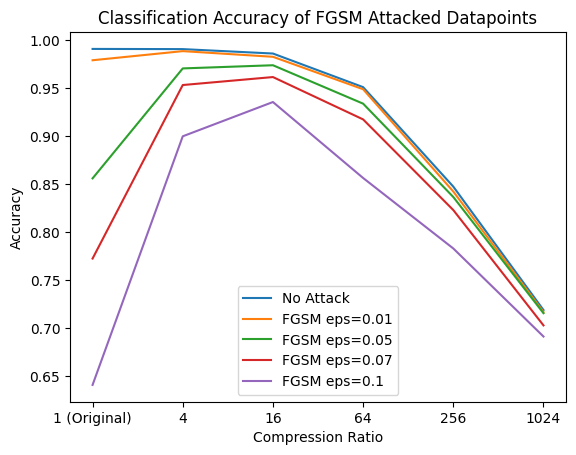

In [64]:
print(accuracies_no_attack)
print(accuracies_fgsm_attack_01)
print(accuracies_fgsm_attack_05)
print(accuracies_fgsm_attack_07)
print(accuracies_fgsm_attack_1)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_fgsm_attack_01, label="FGSM eps=0.01")
plt.plot(layers, accuracies_fgsm_attack_05, label="FGSM eps=0.05")
plt.plot(layers, accuracies_fgsm_attack_07, label="FGSM eps=0.07")
plt.plot(layers, accuracies_fgsm_attack_1, label="FGSM eps=0.1")

plt.title("Classification Accuracy of FGSM Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")

plt.legend()

[0.9911, 0.9909, 0.9863, 0.9513, 0.8477, 0.7192]
[0.9793, 0.9888, 0.9829, 0.9491, 0.8426, 0.7171]
[0.8563, 0.9708, 0.9741, 0.9341, 0.8369, 0.7159]
[0.7728, 0.9535, 0.9618, 0.9177, 0.8233, 0.7032]
[0.6412, 0.9001, 0.9358, 0.8567, 0.7833, 0.6916]


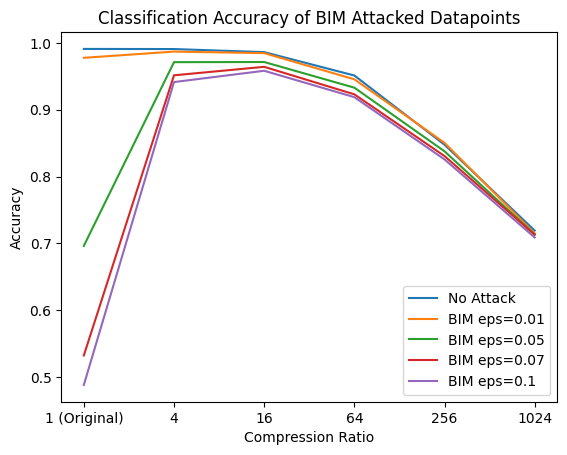

In [65]:
print(accuracies_no_attack)
print(accuracies_bim_attack_01)
print(accuracies_bim_attack_05)
print(accuracies_bim_attack_07)
print(accuracies_bim_attack_1)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_bim_attack_01, label="BIM eps=0.01")
plt.plot(layers, accuracies_bim_attack_05, label="BIM eps=0.05")
plt.plot(layers, accuracies_bim_attack_07, label="BIM eps=0.07")
plt.plot(layers, accuracies_bim_attack_10, label="BIM eps=0.1")

plt.title("Classification Accuracy of BIM Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")

plt.legend()

[0.9905, 0.9899, 0.9857, 0.9518, 0.851, 0.7173]
[0.98, 0.9888, 0.9856, 0.9497, 0.849, 0.7191]
[0.7133, 0.9743, 0.9738, 0.9363, 0.8381, 0.7145]
[0.5497, 0.9649, 0.9689, 0.9252, 0.8303, 0.7092]
[0.4347, 0.9484, 0.9615, 0.9121, 0.8192, 0.7071]


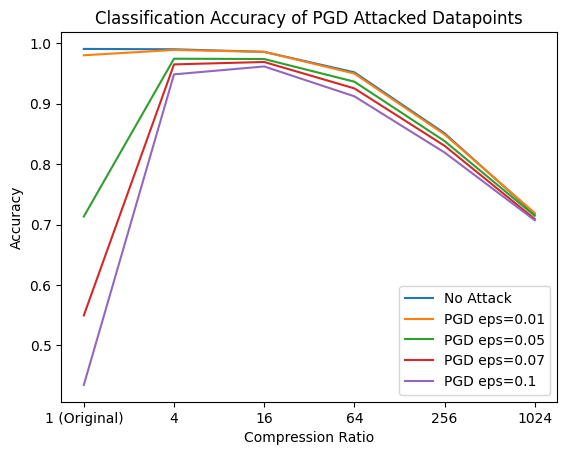

In [85]:
print(accuracies_no_attack)
print(accuracies_pgd_attack_01)
print(accuracies_pgd_attack_05)
print(accuracies_pgd_attack_07)
print(accuracies_pgd_attack_10)

layers = ["1 (Original)", "4", "16", "64", "256", "1024"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_pgd_attack_01, label="PGD eps=0.01")
plt.plot(layers, accuracies_pgd_attack_05, label="PGD eps=0.05")
plt.plot(layers, accuracies_pgd_attack_07, label="PGD eps=0.07")
plt.plot(layers, accuracies_pgd_attack_10, label="PGD eps=0.1")

plt.title("Classification Accuracy of PGD Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")

plt.legend()